# Superlative Cities

### Outline

1. Find cities with most and least severe car accidents
2. Feature Analysis for each city
    - Identify most important and most common weather features
    - Identify most important and most common infrastructure features
    (using random forests?)
3. Plots for each city
    - Show where accidents occur and how severe they are on top of a city map kind of
    - Histograms of accident severity for most common condition per weather feature
    - Histogram of accident severity per infrastructure type side by side per city

### Questions:
- How do I pick which subset of cities to analyze for accident severity?
    - currently doing top 10% freq and then analyzing
    - should I look at variance to determine which cities are viable or something?
- Could clustering be helpful to identify accident hotspots?
- Hypothesis: less variance in location for more dangerous cities related to highways and such
    - How to test this: clean out city lat and longs for places that aren't in the main cluster, then compute variance for accident locations over all the cities and see if it is correlate to mean severity

In [28]:
import pandas as pd
import numpy as np

data = pd.read_csv('US_Accidents_March23.csv')

In [38]:
from matplotlib import pyplot as plt

### Data cleaning

In [29]:
drop_columns = ['ID', 'Source', 'Start_Time', 'End_Time', 
                 'End_Lat', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
                 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 
                 'Amenity', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

df = data.drop(drop_columns, axis=1)

### Identify Cities

In [30]:
def identify_cities():
    city_counts = df['City'].value_counts()

    big_cities = city_counts[city_counts >= 1000].index # cities with >1000 accidents
    df_top = df[df["City"].isin(big_cities)]    # those rows in the dataframe

    mean_sev = df_top.groupby("City")["Severity"].mean().sort_values()
    danger = mean_sev.idxmax()
    safe = mean_sev.idxmin()

    return danger, safe

In [31]:
cities = df.groupby('City')
city_counts = df['City'].value_counts()
city_counts.describe()

count     13678.000000
mean        565.005191
std        4147.357347
min           1.000000
25%           6.000000
50%          35.000000
75%         201.000000
max      186917.000000
Name: count, dtype: float64

In [32]:
# only include cities with more than 1000 accidents for analysis
# pick something else?
big_cities = city_counts[city_counts >= 1000].index # cities with >1000 accidents
df_top = df[df["City"].isin(big_cities)]    # those rows in the dataframe

# describe accidents per these cities
df_values = df_top['City'].value_counts()   
df_values.describe()

count      1218.000000
mean       5194.821839
std       13014.840700
min        1000.000000
25%        1410.250000
50%        2140.500000
75%        3881.000000
max      186917.000000
Name: count, dtype: float64

In [33]:
# look at accident severity for these cities
mean_sev = df_top.groupby("City")["Severity"].mean().sort_values()
mean_sev

City
Abington       1.960621
Tucson         1.963541
Easley         1.975350
Hephzibah      1.977406
Chesnee        1.977427
                 ...   
Stockbridge    2.653401
Joliet         2.656757
Saint Louis    2.670812
Bolingbrook    2.673432
Royal Oak      2.675717
Name: Severity, Length: 1218, dtype: float64

In [34]:
# get cities with highest and lowest accident severity
danger = mean_sev.idxmax()
safe = mean_sev.idxmin()

In [35]:
danger, safe = identify_cities()

### Dangerous Cities

Text(0.5, 1.0, 'Accidents in Royal Oak, most dangerous city')

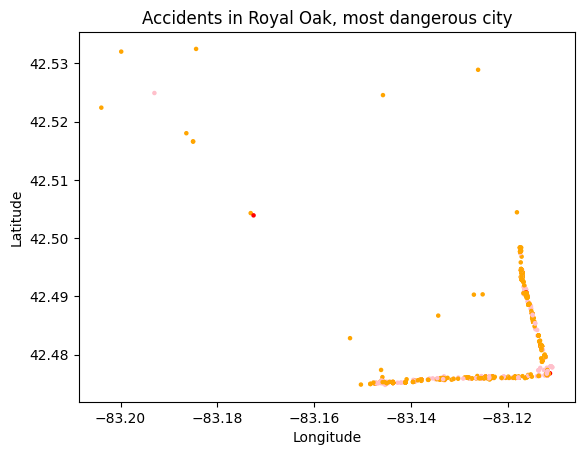

In [73]:
df_danger1 = df.groupby("City").get_group(danger)
df_danger = df_danger1[df_danger1["Start_Lat"] >= 42]   # data cleaning can be adjusted
lat = df_danger["Start_Lat"]
long = df_danger["Start_Lng"]

color_map = {1: "yellow", 2:"orange", 3:"pink", 4:"red"}
colors = df_danger['Severity'].map(color_map)

plt.scatter(long, lat, c=colors, s=5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Accidents in {danger}, most dangerous city")


Text(0.5, 1.0, 'Accidents in Bolingbrook, Second most dangerous city')

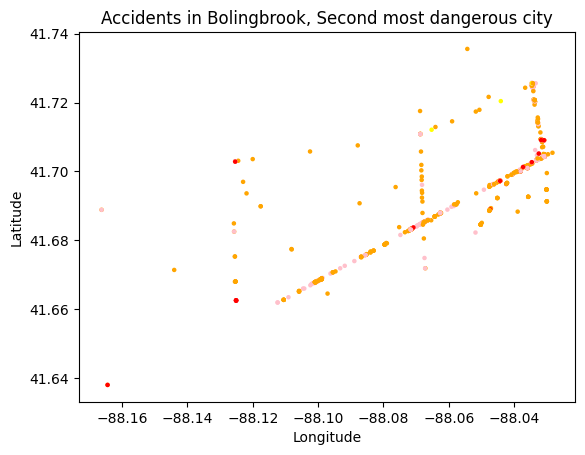

In [74]:
# second most dangerous city
city_counts = df['City'].value_counts()

big_cities = city_counts[city_counts >= 1000].index # cities with >1000 accidents
df_top = df[df["City"].isin(big_cities)]    # those rows in the dataframe

mean_sev = df_top.groupby("City")["Severity"].mean()
second_highest = mean_sev.nlargest(2).index[1]

df_sh = df.groupby("City").get_group(second_highest)
# df_safe = df_safe1[df_safe1["Start_Lng"] >= -73]   # data cleaning can be adjusted
lat = df_sh["Start_Lat"]
long = df_sh["Start_Lng"]

color_map = {1: "yellow", 2:"orange", 3:"pink", 4:"red"}
colors = df_sh['Severity'].map(color_map)

plt.scatter(long, lat, c=colors, s=5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Accidents in {second_highest}, Second most dangerous city")


### Safest Cities

Text(0.5, 1.0, 'Accidents in Abington area 1, safest city')

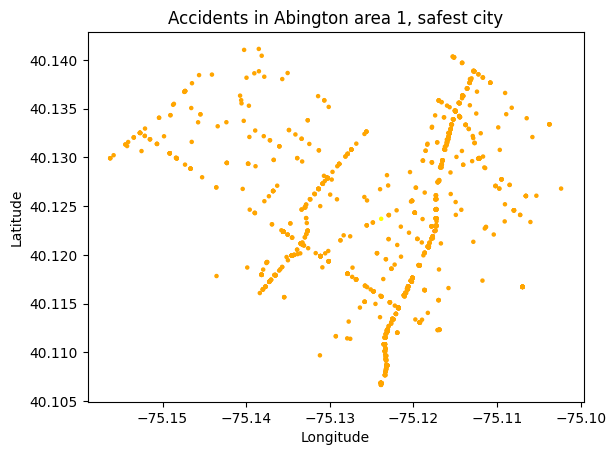

In [76]:
df_safe1 = df.groupby("City").get_group(safe)
df_safe = df_safe1[df_safe1["Start_Lng"] <= -73]   # data cleaning can be adjusted
lat = df_safe["Start_Lat"]
long = df_safe["Start_Lng"]

color_map = {1: "yellow", 2:"orange", 3:"pink", 4:"red"}
colors = df_safe['Severity'].map(color_map)

plt.scatter(long, lat, c=colors, s=5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Accidents in {safe} area 1, safest city")

Text(0.5, 1.0, 'Accidents in Abington area 2, safest city')

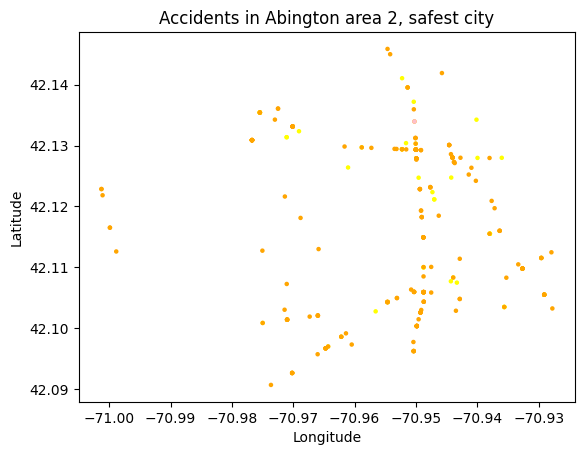

In [77]:
df_safe1 = df.groupby("City").get_group(safe)
df_safe = df_safe1[df_safe1["Start_Lng"] >= -73]   # data cleaning can be adjusted
lat = df_safe["Start_Lat"]
long = df_safe["Start_Lng"]

color_map = {1: "yellow", 2:"orange", 3:"pink", 4:"red"}
colors = df_safe['Severity'].map(color_map)

plt.scatter(long, lat, c=colors, s=5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Accidents in {safe} area 2, safest city")

Text(0.5, 1.0, 'Accidents in Tucson, Second safest city')

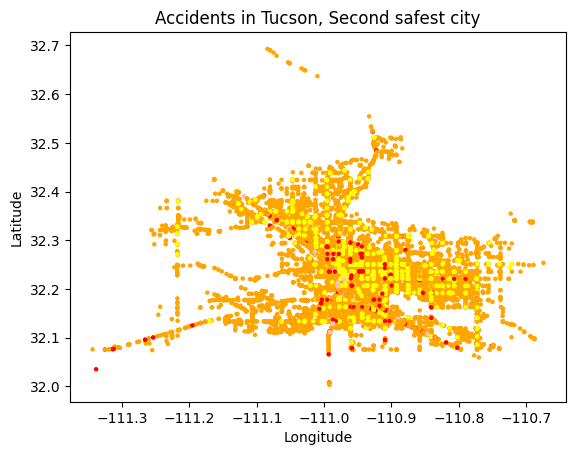

In [79]:
# Let's try a different city
city_counts = df['City'].value_counts()

big_cities = city_counts[city_counts >= 1000].index # cities with >1000 accidents
df_top = df[df["City"].isin(big_cities)]    # those rows in the dataframe

mean_sev = df_top.groupby("City")["Severity"].mean()
second_safest = mean_sev.nsmallest(2).index[1]

df_ss1 = df.groupby("City").get_group(second_safest)
df_ss = df_ss1[df_ss1["Start_Lat"] >= 31.8]   # data cleaning can be adjusted
lat = df_ss["Start_Lat"]
long = df_ss["Start_Lng"]

color_map = {1: "yellow", 2:"orange", 3:"pink", 4:"red"}
colors = df_ss['Severity'].map(color_map)

plt.scatter(long, lat, c=colors, s=5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Accidents in {second_safest}, Second safest city")